# TRAINING A CLASSIFIER

## 参考资料

> https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py  


In [1]:
import torch
print(torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

1.5.0


## 关于数据

CIFAR-10 Dataset：

> Class: "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"  
> Sizes: 3 x 32 x 32 (nChannels x Height x Width)  

PyTorch 中关于数据集的部分：

> `torchvision.datasets` 中集成常用视觉数据集  
> `torch.utils.data.DataLoader` 数据导入器基类  
> `torch.utils.data.Dataset` 数据集基类  


## 训练图片分类器

### 导入数据


In [2]:
# `torchvision.datasets`输出为PILImage格式数据，需要进行数据归一化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5,.5,.5), (.5,.5,.5))
])

In [3]:
# CIFAR-10训练集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

Files already downloaded and verified


In [4]:
# CIFAR-10测试集
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=4,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified


In [5]:
# CIFAR-10类别映射
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

### 探索数据


In [6]:
images, labels = iter(trainloader).next()
print(len(images), images[0].size(), labels[0])

4 torch.Size([3, 32, 32]) tensor(8)


In [7]:
# 辅助方法：展示图片
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    # plt.imshow() W x H x C
    # `np.transpose()` 方法用于交换数组轴的位置
    # 备注：对应 PyTorch 的 `tensor.permute()` 方法
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

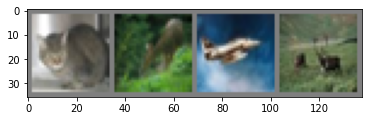

       cat       deer      plane       deer


In [8]:
images, labels = iter(trainloader).next()
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### 搭建神经网络


In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 损失函数&优化器


In [10]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 训练&保存模型


In [11]:
print('Start Training')
for epoch in range(1):
    running_loss = 0.
    for i, data in enumerate(trainloader, start=1):
        # 获取一个Batch的数据，data = (images, labels)
        inputs, labels = data
        # 所有梯度缓冲区清零
        optimizer.zero_grad()
        # forward
        outputs = net(inputs)
        # loss
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # update
        optimizer.step()
        # 打印各种指标
        running_loss += loss.item()
        if i % 2000 == 0:    # print every 2000 mini-batches
            print('[{:d}, {:5d}] loss: {:.3f}'.format
                  (epoch+1, i, running_loss/2000))
            running_loss = 0.0
print('Finish Training')

Start Training
[1,  2000] loss: 2.226
[1,  4000] loss: 1.902
[1,  6000] loss: 1.706
[1,  8000] loss: 1.598
[1, 10000] loss: 1.537
[1, 12000] loss: 1.480
Finish Training


In [ ]:
# 法一：仅保存模型参数
torch.save(net.state_dict(), './cifar_net.pth')
# 法二：保存完整模型（包括模型信息）
# torch.save(net, './cifar_net.pth')

In [ ]:
# 法一：仅加载模型参数
net = Net()
net.load_state_dict(torch.load('./cifar_net.pth'))
# 法二：加载完整模型（包括模型信息）
# net = torch.load('./cifar_net.pth')

### 测试模型


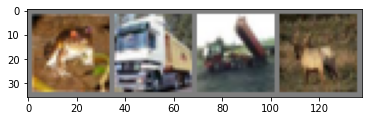

GroundTruth:
       frog      truck      truck       deer
Predicted: 
       deer      truck      truck       deer


In [12]:
images, labels = iter(testloader).next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:\n',
      ' '.join('%10s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, axis=1)
print('Predicted: \n',
      ' '.join('%10s' % classes[predicted[j]] for j in range(4)))

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the {:d} test images: {:.2%}'
      .format(total, correct/total))

Accuracy of the network on the 50000 test images: 48.69%


### 单GPU训练


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 注意，使用GPU训练时，模型与数据都需要转到GPU中
inputs, labels = iter(trainloader).next()
net.to(device)
inputs, labels = inputs.to(device), labels.to(device)